## Second exercice
This second notebook is intended to demonstrate the interest of using _iid variable density sampling_
either from:
* **optimal distributions** from the CS theory on orthonormal systems for Shannon wavelets derived in:
    -   Chauffert et al, "Variable density compressed sensing in MRI. Theoretical vs heuristic sampling strategies", Proc. 10th IEEE ISBI 2013: 298-301
    -  Chauffert et al, "Variable Density Sampling with Continuous Trajectories" SIAM Imaging Sci, 2014;7(4):1992-1992) 

* or from handcrafted densities parameterized by the decay $\eta$: 
$$
p(k_x,k_y) =1/\left(k_x^2+k_y^2\right)^{\eta/2}, \quad \eta \simeq 3.
$$

* Author: Philippe Ciuciu (philippe.ciuciu@cea.fr)
* Date: 04/02/2019
* Target: [ISBI'19 tutorial](https://biomedicalimaging.org/2019/tutorials/) on **Recent  advances in acquisition and reconstruction for Compressed Sensing MRI**
* Revision: 01/05/2020 for ATSI MSc hands-on session at Paris-Saclay University.

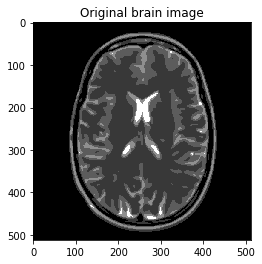

In [15]:
#DISPLAY BRAIN PHANTOM
#%matplotlib nbagg
%matplotlib inline

import os.path as op
import os
import math
import cmath
import sys

import numpy as np
import matplotlib.pyplot as plt

from skimage import data, io, filters

# get current working dir
cwd = os.getcwd()
# cwd= "/"
dirimg_2d = op.join(cwd,"../data")
img_size = 512   #256
FOV = 0.2 #field of view in m
pixelSize = FOV/img_size

#load data file corresponding to the target resolution
filename = "BrainPhantom%s.png" % img_size
mri_filename = op.join(dirimg_2d, filename)
mri_img = io.imread(mri_filename)
# mri_img = io.imread(mri_filename, as_gray=True)
# print(mri_img.dtype)
plt.figure()
plt.title("Brain Phantom, size = "+ str(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.title("Original brain image")
plt.show()

Text(0.5, 1.0, 'Variable density sampling mask')

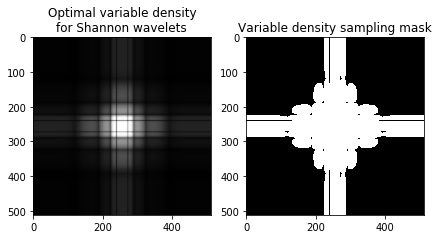

In [16]:
# Load target sampling distribution (precalculated in Matlab)
import numpy as np
from scipy.io import loadmat

img_size = 512
# see Chauffert et al, IEEE ISBI 2013 for the computation of optimal sampling densities
densities = loadmat(op.join(dirimg_2d, "2d_sampling_densities.mat"))

if img_size == 512:
    opt_density = densities['distrib2d_N512_sym10']  # generated using orthogonal Symmlet10 wavelet transform for img size 512x512
else:
    opt_density = densities['distrib2d_N256_sym10']  # generated using orthogonal Symmlet10 wavelet transform for img size 256x256

# Generate Cartesian variable density mask
# change the value below if you want to change the final subsampling mask
threshold = 10. * opt_density.min()  # sys.float_info.epsilon \simeq 2e-16
kspace_mask = np.zeros((img_size, img_size), dtype="float64")
kspace_mask = np.where(opt_density > threshold, 1, kspace_mask)

#plt.figure()
#plt.title("Optimal variable density for Shannon wavelets")
#plt.imshow(opt_density)
#plt.show()

fig, axs = plt.subplots(1, 2, figsize=(7, 4) )
axs[0].imshow(opt_density, cmap='Greys_r')
axs[0].set_title("Optimal variable density\nfor Shannon wavelets")
axs[1].imshow(kspace_mask, cmap='Greys_r')
axs[1].set_title("Variable density sampling mask")

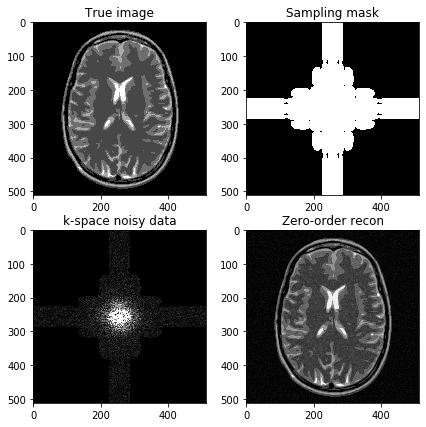

In [17]:
#import numpy.fft as fft

norm = "ortho"
#norm = None

def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)

# Generate the kspace data: first Fourier transform the image
kspace_data = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Mask data to perform subsampling
kspace_data *= kspace_mask

# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(7, 7) )
axs[0, 0].imshow(mri_img, cmap='Greys_r')
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_mask, cmap='Greys_r')
axs[0, 1].set_title("Sampling mask")
axs[1,0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
# axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(image_rec0), cmap='Greys_r')
axs[1, 1].set_title("Zero-order recon")
plt.show()

[[0.22507908 0.22463904 0.22419987 ... 0.22419987 0.22463904 0.22507908]
 [0.22463904 0.22419814 0.22375811 ... 0.22375811 0.22419814 0.22463904]
 [0.22419987 0.22375811 0.22331721 ... 0.22331721 0.22375811 0.22419987]
 ...
 [0.22419987 0.22375811 0.22331721 ... 0.22331721 0.22375811 0.22419987]
 [0.22463904 0.22419814 0.22375811 ... 0.22375811 0.22419814 0.22463904]
 [0.22507908 0.22463904 0.22419987 ... 0.22419987 0.22463904 0.22507908]]


<IPython.core.display.Javascript object>


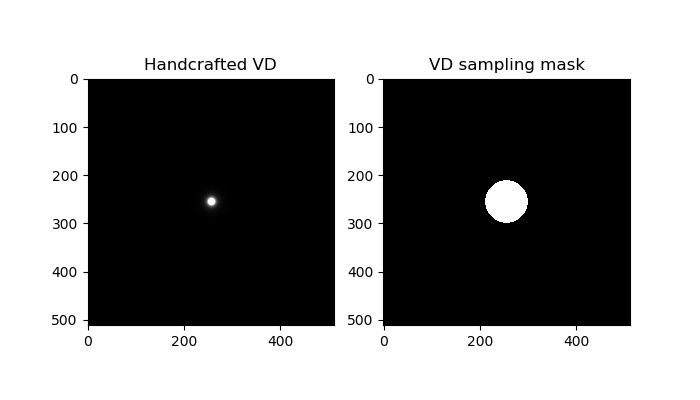

Text(0.5, 1.0, 'VD sampling mask')

In [13]:
# Now construct by hands a variable sampling distribution 
# You can change the decay to modify the decreasing behavior in the center of k-space
# the larger the decay, the faster the decrease from low to high-frequencies
decay = 3
x = np.linspace(-1. / (2. * np.pi), 1. / (2. * np.pi), img_size)
X, Y = np.meshgrid(x, x)
r = np.sqrt(X ** 2 + Y ** 2)
print(r)
p_decay = np.power(r,-decay)
p_decay = p_decay/np.sum(p_decay)

#print(p_decay.max())
#print(p_decay.min())

# change the value below if you want to change the final subsampling mask
threshold = 2* opt_density.min()  # sys.float_info.epsilon \simeq 2e-16
kspace_mask = np.zeros((img_size,img_size), dtype="float64")
kspace_mask = np.where(p_decay > threshold, 1, kspace_mask)

fig, axs = plt.subplots(1, 2, figsize=(7, 4))
axs[0].imshow(p_decay, cmap='Greys_r', vmax=0.001 * np.abs(p_decay).max())
axs[0].set_title("Handcrafted VD")
axs[1].imshow(kspace_mask, cmap='Greys_r') 
axs[1].set_title("VD sampling mask")

<IPython.core.display.Javascript object>


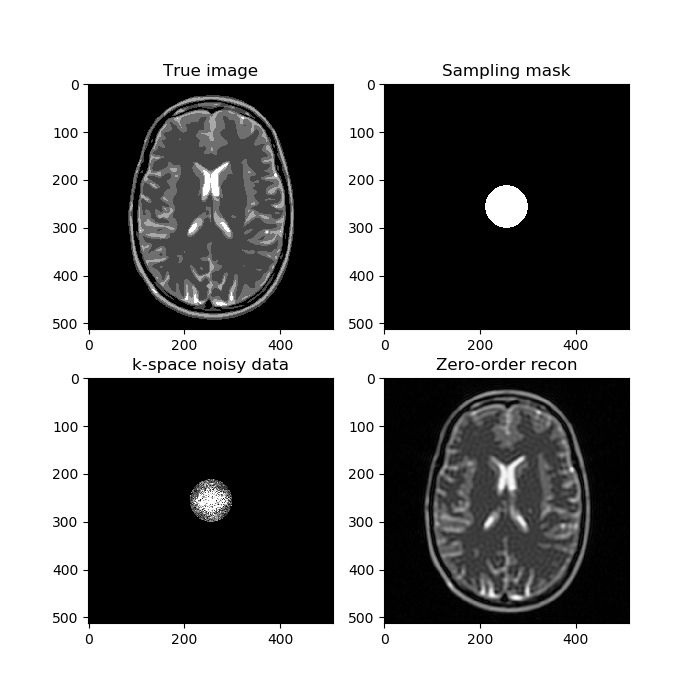

In [14]:
# Generate the kspace data: first Fourier transform the image
kspace_data = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Mask data to perform subsampling
kspace_data *= kspace_mask

# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(7, 7))
axs[0, 0].imshow(mri_img, cmap='Greys_r')
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_mask, cmap='Greys_r')
axs[0, 1].set_title("Sampling mask")
axs[1, 0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(image_rec0), cmap='Greys_r')
axs[1, 1].set_title("Zero-order recon")
plt.show()